# Fitting DEBtox2019 to data

In [163]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
from debtox2019 import *
import seaborn as sns

## Default sim

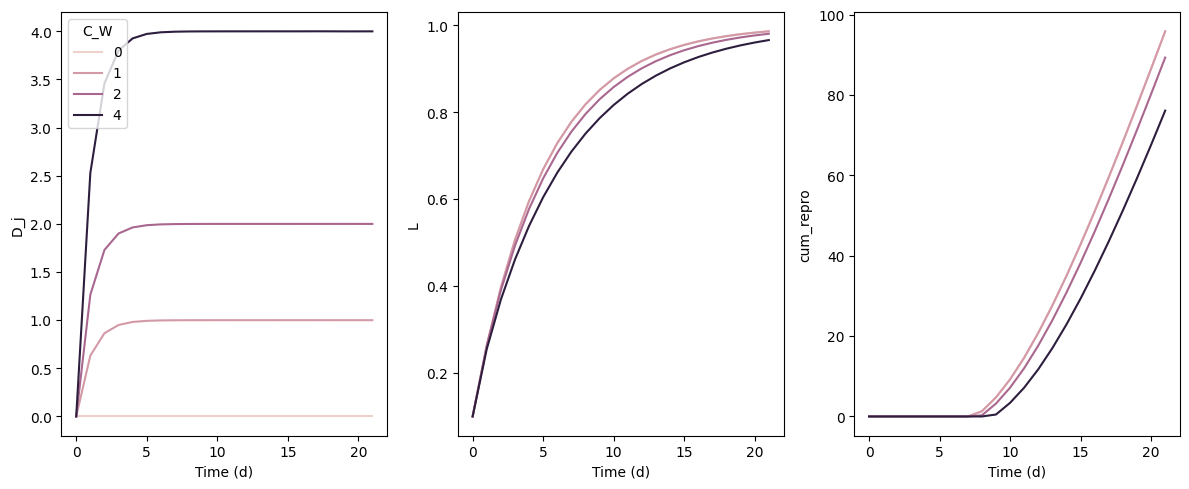

In [165]:
p = defaultparams_debtox2019.copy()

p['k_D'] = 1
p['pmoa'] = 'G'
p['b'] = .1

sim = simulate_debtox(p)
fig, ax = plot_debtox2019_sim(sim, group = 'C_W')

## Exploring the model with widgets

With `ipywidgets` installed, we can interactively play with the model to get a feeling of how the parameters affect model output.

In [166]:
# TODO: widget is not as smooth is it could be, 
# can we accelerate the plotting?
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
p = defaultparams_debtox2019.copy()
p.update({'R_m' : 8, 'pmoa' : 'G'})

@interact(
        r_B=widgets.FloatSlider(min=0, max=1, step=.1, value=.2), 
        L_0 = widgets.FloatSlider(min=0.01, max=1, step=.1, value=.1), 
        L_m=widgets.FloatSlider(min=0.01, max=5, step=.1, value=5.), 
        L_p=widgets.FloatSlider(min=0.1, max=4, step=.1, value=.5), 
        k_D = widgets.FloatSlider(min=0, max=1., logstep=.1, value=1),
        z = 1., 
        b = widgets.FloatSlider(min=0.01, max=1, step=.05, value=.5)
        )
def wig(r_B, L_0, L_m, L_p, k_D, z, b):


    p.update({
        'r_B' : r_B, 'L_0': L_0, 'L_m' : L_m, 'L_p' : L_p, 
        'k_D' : k_D, 'z' : z, 'b' : b
        })

    sim = simulate_debtox(p)

    fig, ax = plot_debtox2019_sim(sim)
    ax[1].set_ylim(0, 5)
    ax[2].set_ylim(0, 150)

    sns.despine()

    return None

interactive(children=(FloatSlider(value=0.2, description='r_B', max=1.0), FloatSlider(value=0.1, description='…

## Loading & plotting data

In [167]:
from modelfitting import *

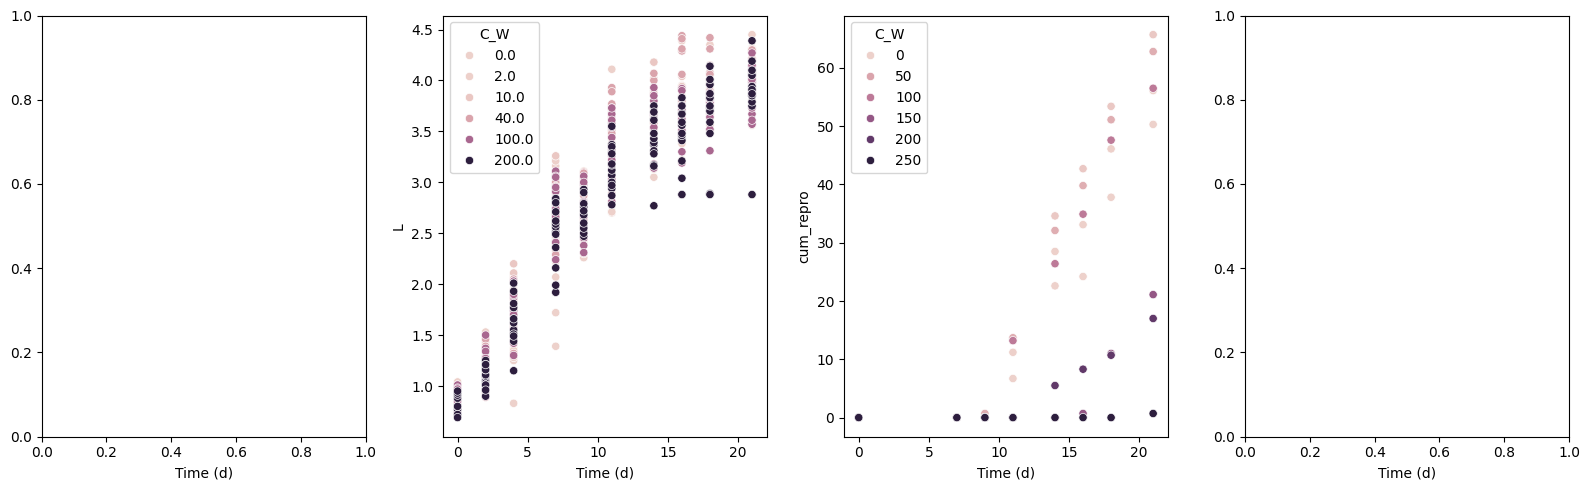

In [197]:
fit = setup_fit(
    paths = {
        'growth': ('../azoxy_static_growth_tidy.csv', {'skiprows' : 4}),
        'repro' : ('../azoxy_static_repro_tidy.csv', {'skiprows' : 4})
    },
    colnames = {
        'time' : 't_day', 
        'exposure' : 'C_W', 
        'length' : 'length_mm',
        'cum_repro' : 'cum_repro'
    }
)

fig, ax = plot_debtox2019_data(fit.data, layout='cols')

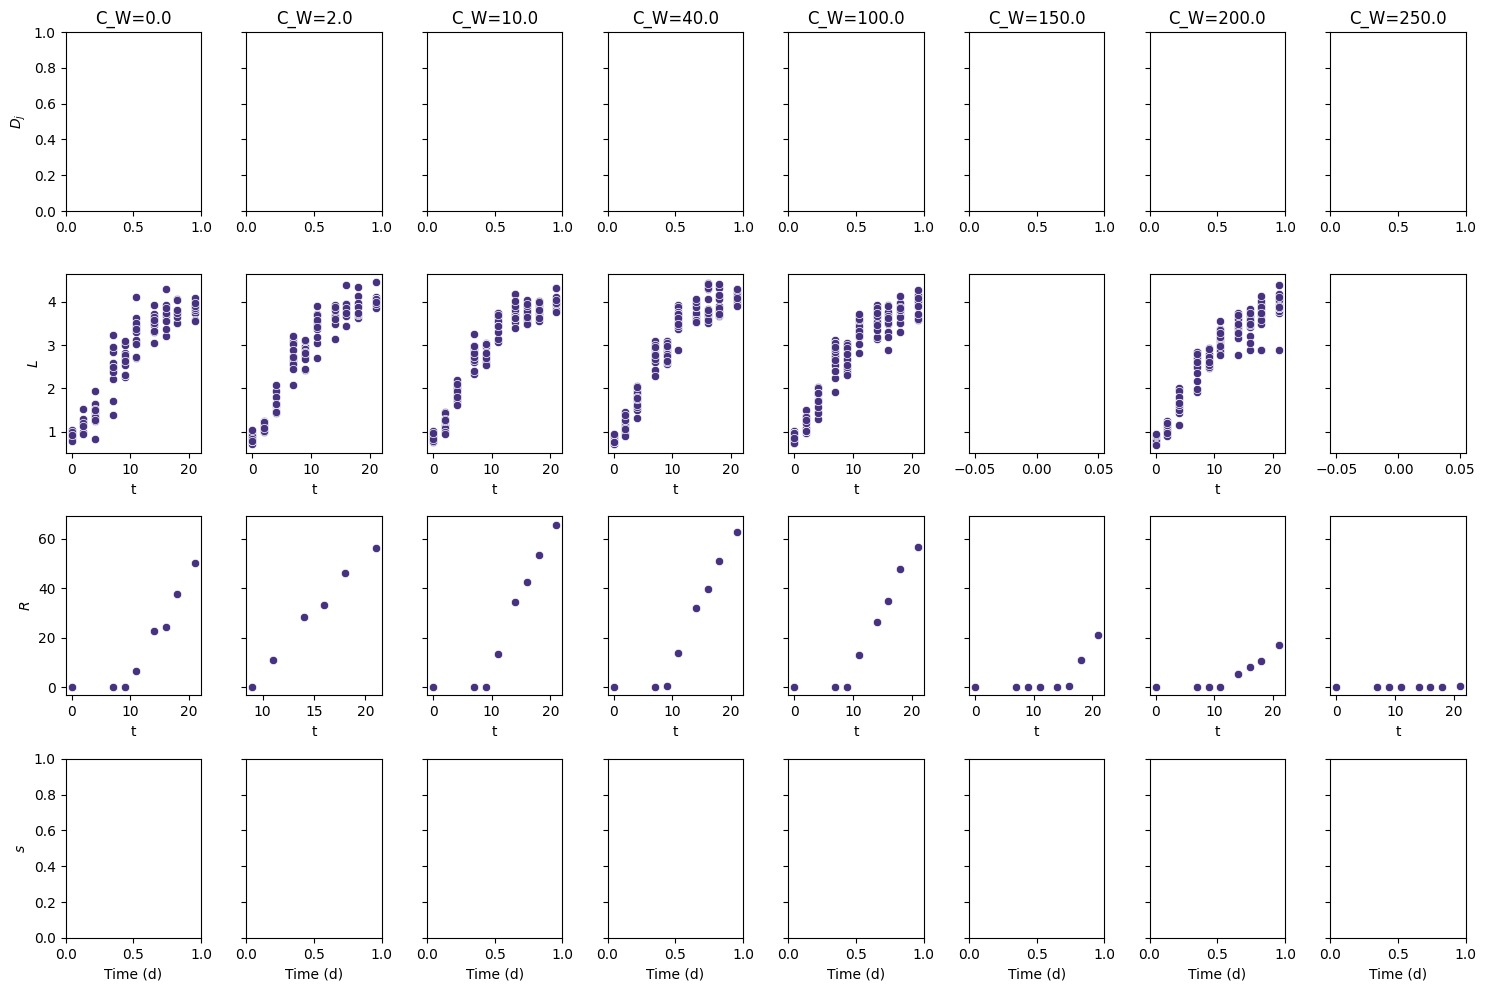

In [198]:
fig, ax = fit.plot_data(layout='grid')
fig.set_size_inches(15,10)
plt.tight_layout(pad=1.04)

In [202]:
fit.loss = loss_debtox

In [220]:
fit.intguess

{'L_0': 0.1, 'L_m': 4.0, 'L_p': 3, 'r_B': 0.2, 'R_m': 10}

In [223]:
fit.intguess = {
    'L_0' : 1,
    'L_m' : 4.,
    'L_p' : 3,
    'r_B' : .2,
    'R_m' : 10
}

fit.fit_controls(update_defaults=True, method='Powell')

Fitted model using Powell method. Results stored in `optimization_result`
update_defaults is set to True, updating default_params in the ModelFit object based on the estimated parameters


In [217]:
from scipy.optimize import differential_evolution

obj = fit.define_objective_function()

# bounds for the boundaries, with ideas on how to get them automatically
bounds = [
    # L_0. could be something like:
    # if we have a measurement at t=0, take observed L_0 plusmin 1 on a mean-centered scale
    # otherwise, interpolate linearly to t=0, take that as "observed" L_0 
    (.5, 1.5),
    # L_m. if we have a measurement at t=t_max, take that +- 1 mean-centered
    # when L is converted to a unit that represents it on a single-digit scale
    (3, 5),
    # L_p: TBD
    (2, 4),
    # r_B: this is probably fine for most cases
    (.1, 1), 
    # R_m: maybe average the rates from the last couple of observations, 
    # add plusmin some percentage
    (2., 20)
]

opt_de = differential_evolution(obj, bounds)

c:\Users\shansul\.conda\envs\mempyDEBtest\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\shansul\.conda\envs\mempyDEBtest\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\shansul\.conda\envs\mempyDEBtest\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\shansul\.conda\envs\mempyDEBtest\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


KeyboardInterrupt: 

In [ ]:
opt_de

In [ ]:
dict(zip(fit.intguess.keys(), opt.x)) # Powell

{'L_0': np.float64(0.10220891259701614),
 'L_m': np.float64(3.8626474930486627),
 'L_p': np.float64(2.940646872550497),
 'r_B': np.float64(0.20082508082898115),
 'R_m': np.float64(10.37793249875822)}

In [ ]:
dict(zip(fit.intguess.keys(), opt.x)) # Nelder-Mead

{'L_0': np.float64(0.10220891259701614),
 'L_m': np.float64(3.8626474930486627),
 'L_p': np.float64(2.940646872550497),
 'r_B': np.float64(0.20082508082898115),
 'R_m': np.float64(10.37793249875822)}

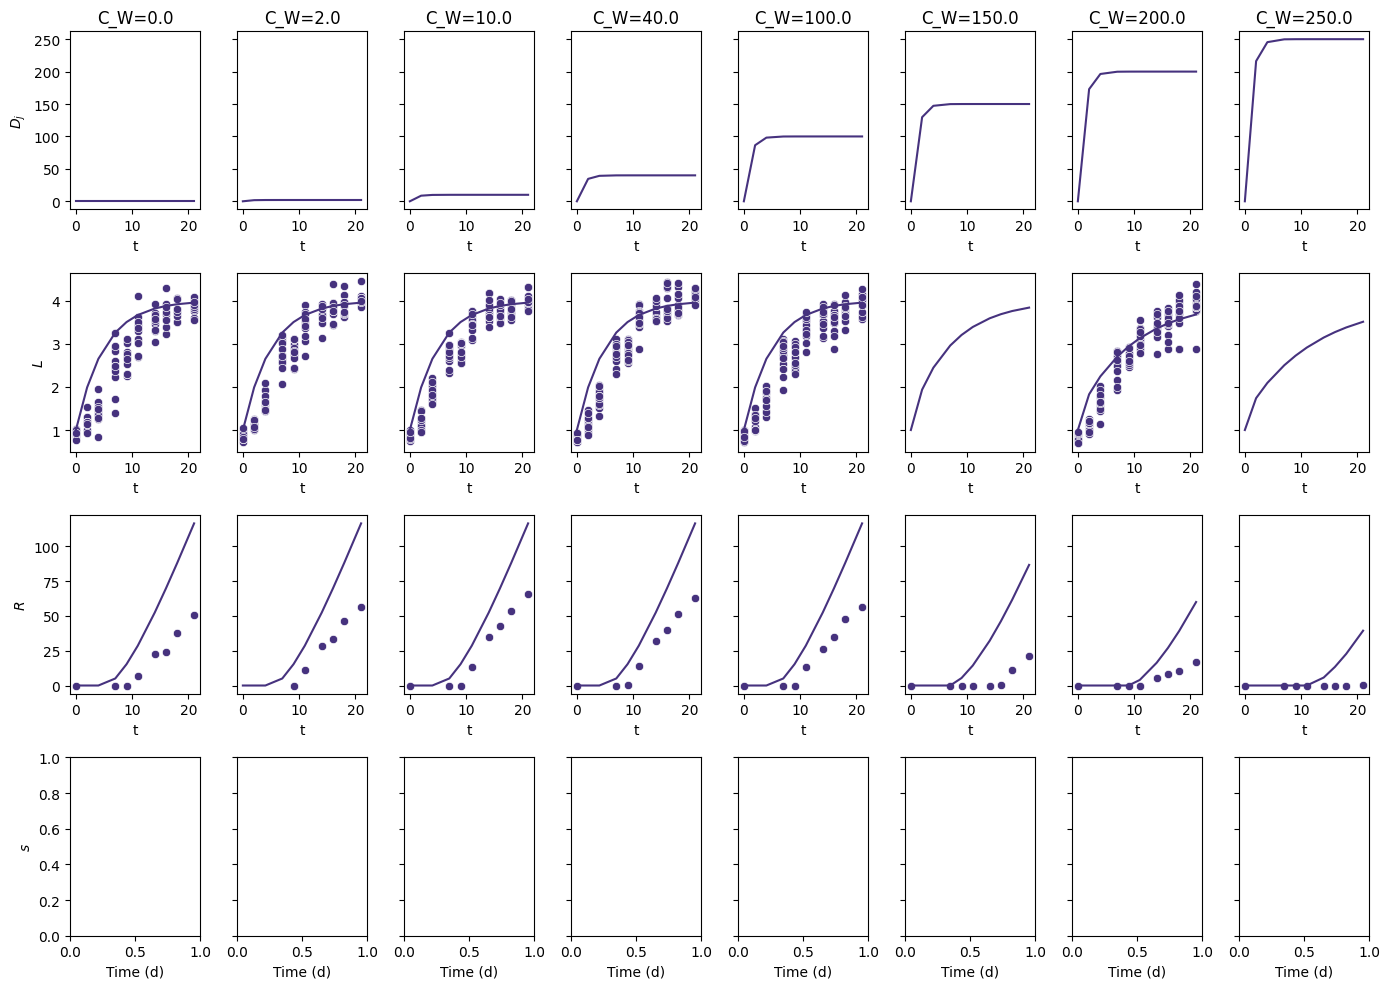

In [ ]:
fit.default_params['R'] = 0

fit.intguess = {
    'L_0' : 1, 
    'L_m' : 4, 
    'L_p' : 3, 
    'R_m' : 10, 
    'k_D' : 1,
    'z' : 100,
    'b' : 1e-2
    }

sim = fit.simulator(fit.intguess)

fig, ax = fit.plot_data(layout='grid')
fig.set_size_inches(14,10)

for (i,C_W) in enumerate(sim.C_W.unique()):
    df = sim.loc[sim.C_W==C_W]
    sns.lineplot(df, x = 't', y = 'D_j', ax = ax[0,i])
    sns.lineplot(df, x = 't', y = 'L', ax = ax[1,i])
    sns.lineplot(df, x = 't', y = 'R', ax = ax[2,i])

plt.tight_layout()

In [192]:
fit.run_optimization()

c:\Users\shansul\Documents\mempyDEB\examples\debtox2019.py:28: RuntimeWarning: invalid value encountered in scalar divide
  dR = (L>p['L_p']) * np.maximum(0, p['R_m']*(1/(1+s_R))*(p['f']*p['L_m']*L**2*(1-s_A)-(p['L_p']**3)*(1+s_M))/(p['L_m']**3 - p['L_p']**3))


KeyboardInterrupt: 

In [ ]:
fit.p_opt

In [ ]:
fit.run_optimization(method = 'Powell')

In [ ]:
fit.p_opt